## Overview

Using [Gemma2_9b](https://huggingface.co/unsloth/gemma-2-9b-it-bnb-4bit) from unsloth team as base + LoRA adapter on top of it

using finetuned Gemma2 for multilingual tasks : https://huggingface.co/BAAI/bge-multilingual-gemma2  
-> A LLM-based multilingual embedding model, trained on a diverse range of languages and tasks. 

LoRA approximates model's weigths by factorising Q, K, V matrices into much smaller ones.  

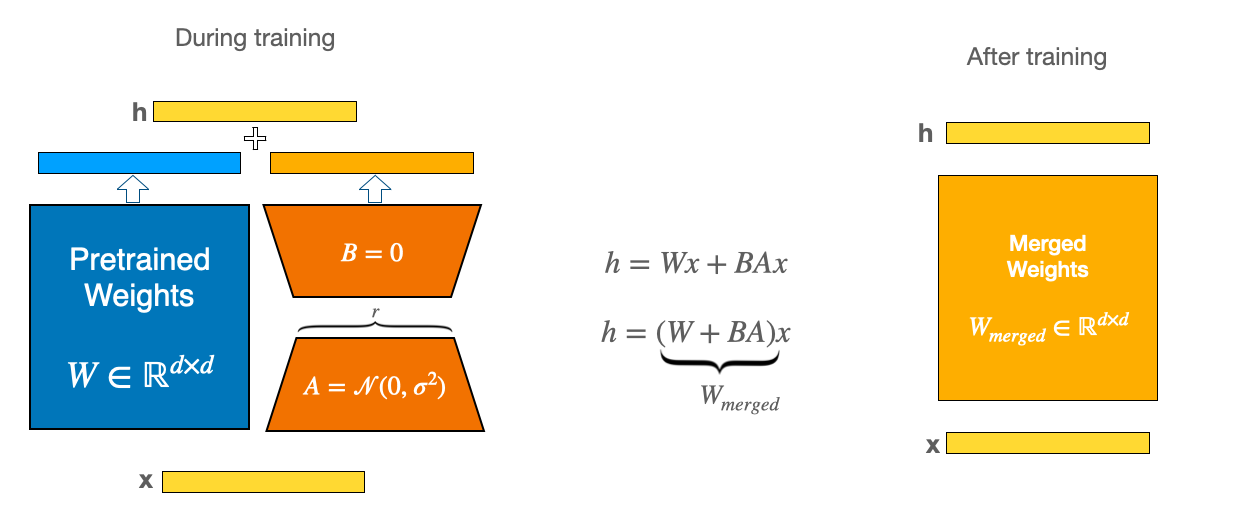  

Only those matrices will be updated during trainning -> reduce GPU memory usage. This is done with very little loss (casualities) on final metric.

> Note that QLoRA only quantize LLM's weights in low precision (e.g. 8-bit) while the computation of forward/backward are done in higher precision (e.g. 16-bit) and LoRA adapter's weights are also kept in higher precision.

HugginFace's Quantization Page : https://huggingface.co/docs/peft/developer_guides/quantization

Inspiration notebook https://www.kaggle.com/code/emiz6413/inference-gemma-2-9b-4-bit-qlora

Note : This will probably take a long time, i need to take some of mine to check for external compute resource for full trainning:
- RunPod : https://docs.runpod.io/tutorials/pods/run-fooocus
- Paperspace : https://www.paperspace.com/notebooks

## Imports

In [3]:
# gemma-2 is available from transformers>=4.42.3

import transformers as trsf
print("Transformers:", trsf.__version__)

#!pip install -U "transformers>=4.42.3" bitsandbytes accelerate peft

Transformers: 4.46.3


In [4]:
import os
import copy
from dataclasses import dataclass

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import Tensor

#from datasets import Dataset

from tqdm import tqdm

from transformers import (
    BitsAndBytesConfig,
    Gemma2ForSequenceClassification,
    Gemma2Model,
    GemmaTokenizerFast,
    Gemma2Config,
    AutoTokenizer,
    AutoModel,
    PreTrainedTokenizerBase, 
    EvalPrediction,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

import ModelsUtils as Utils
#import wsdm_modelutils as Utils

In [5]:
print('Torch version:', torch.__version__)
print('Torch is build with CUDA:', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Torch device : {device}')
print('------------------------------')

Torch version: 2.5.1+cu118
Torch is build with CUDA: True
Torch device : cuda
------------------------------


## Config

In [6]:
MINI_RUN = False
SEED = 707
ORIGINAL = True

In [7]:
runType = "MINI" if MINI_RUN else "FULL"
original = "original" if ORIGINAL else "custom"

In [8]:
#---------------------------------------------------------------------------------------------------
class ConfigMini:
    output_dir: str = "output"
    checkpoint: str = "unsloth/gemma-2-9b-it-bnb-4bit"  # 4-bit quantized gemma-2-9b-instruct
    max_length: int = 256
    n_splits: int = 5
    fold_idx: int = 0
    optim_type: str = "adamw_8bit"
    per_device_train_batch_size: int = 2
    gradient_accumulation_steps: int = 2  # global batch size is 8 
    per_device_eval_batch_size: int = 8
    n_epochs: int = 1
    freeze_layers: int = 16  # there're 42 layers in total, we don't add adapters to the first 16 layers
    lr: float = 2e-4
    warmup_steps: int = 20
    lora_r: int = 16
    lora_alpha: float = lora_r * 2
    lora_dropout: float = 0.05
    lora_bias: str = "none"
    spread_max_length = False  # whether to apply max_length//3 on each input or max_length on the concatenated input

#---------------------------------------------------------------------------------------------------
class ConfigFull:
    output_dir: str = "output"
    checkpoint: str = "unsloth/gemma-2-9b-it-bnb-4bit"  # 4-bit quantized gemma-2-9b-instruct
    max_length: int = 1024#2048
    n_splits: int = 5
    fold_idx: int = 0
    optim_type: str = "adamw_8bit"
    per_device_train_batch_size: int = 2
    gradient_accumulation_steps: int = 2  # global batch size is 8 
    per_device_eval_batch_size: int = 8
    n_epochs: int = 1
    freeze_layers: int = 16  # there're 42 layers in total, we don't add adapters to the first 16 layers
    lr: float = 2e-4
    warmup_steps: int = 20
    lora_r: int = 16
    lora_alpha: float = lora_r * 2
    lora_dropout: float = 0.05
    lora_bias: str = "none"
    spread_max_length = False  # whether to apply max_length//3 on each input or max_length on the concatenated input

In [9]:
config = ConfigMini() if MINI_RUN else ConfigFull()

### Paths

In [10]:
# for AutoModel and auto tokenizer
#base_model_path = '/kaggle/input/bge-multilingual-gemma2-fp16/pytorch/default/1/bge-multilingual-gemma2-fp16'
#base_model_path = '/kaggle/input/bge-multilingual-gemma2-fp16/pytorch/default/1/bge-multilingual-gemma2-fp16-4bit'
base_model_path = '../BaseModel/bge-multilingual-gemma2-fp16-4bit'


# peft pre saved locally
#peft_model_path = '/kaggle/input/peftchkpt_original/pytorch/default/1/'
peft_model_path = '../Checkpoints/'
checkpoint_name = "test3"

#df = pd.read_csv('/kaggle/input/wsdm-preprocessed-full-original/train_preprocessed_FULL_original.csv')
#dataframe_path = '/kaggle/input/train-preprocessed-mini-original/train_preprocessed_MINI_original.csv'
dataframe_path = '../Data/Preprocessed/train_preprocessed_MINI_original.csv'


## Trainning Args

In [11]:
training_args = TrainingArguments(
    output_dir="output",
    overwrite_output_dir=True,
    report_to="none",
    num_train_epochs=config.n_epochs,
    per_device_train_batch_size=config.per_device_train_batch_size,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    per_device_eval_batch_size=config.per_device_eval_batch_size,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="steps",
    save_steps=200,
    optim=config.optim_type,
    fp16=True,
    learning_rate=config.lr,
    warmup_steps=config.warmup_steps,
)

## LoRA Config

In [12]:
lora_config = LoraConfig(
    r=config.lora_r,
    lora_alpha=config.lora_alpha,
    # only target self-attention
    target_modules=["q_proj", "k_proj", "v_proj"],
    #layers_to_transform=[i for i in range(42) if i >= config.freeze_layers],
    lora_dropout=config.lora_dropout,
    bias=config.lora_bias,
    task_type=TaskType.FEATURE_EXTRACTION, #SEQ_CLS
)

___________________________________________________________________________

## Data

In [13]:
df = pd.read_csv(dataframe_path)
df.head(1)

,id,prompt,response_a,response_b,winner,model_a,model_b,language,encode_fail,class_label,prompt_len,response_a_len,response_b_len
0,6e09f2c1136cd1540b627393f8ec1f583618a68af19b4a...,tạo cho tôi filter giá tăng giần hoặc giảm giầ...,Dưới đây là một ví dụ về cách tạo bộ lọc giá t...,"```jsx\nimport React, { useState, useEffect } ...",model_b,claude-3-5-sonnet-20240620,gemini-1.5-pro-002,Vietnamese,False,1,73,2063,3469


In [14]:
df['prompt'] = df['prompt'].astype(str)
df['response_a'] = df['response_a'].astype(str)
df['response_b'] = df['response_b'].astype(str)

## Tokenize

In [15]:
tokenizer = AutoTokenizer.from_pretrained(base_model_path)
tokenizer.add_eos_token = True      # We'll add <eos> at the end
tokenizer.padding_side = "right"

## Split

In [16]:
df_train, df_valid = train_test_split(df, test_size=0.1, random_state=SEED)

## Data Loader

In [17]:
# Prepare dataset and dataloader
dataset_train = Utils.ChatbotArenaDataset(df_train, tokenizer, max_length=config.max_length)
dataloader_train = Utils.DataLoader(dataset_train, batch_size=config.per_device_train_batch_size, shuffle=True)

dataset_valid = Utils.ChatbotArenaDataset(df_valid, tokenizer, max_length=config.max_length)
dataloader_valid = Utils.DataLoader(dataset_valid, batch_size=config.per_device_train_batch_size, shuffle=True)

## Model

In [18]:
#quantization_config = BitsAndBytesConfig(load_in_4bit=True)

predictionModel = Utils.custom_load_model_chkpt(
                        baseModelPath=base_model_path,
                        peftModelPath=peft_model_path,
                        checkpointName=checkpoint_name, 
                        quantization_config=None, 
                        optimizer=None)


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 2/2 [00:19<00:00,  9.51s/it]
f:\Projects\Kaggle\2_WSDMCup_Multilingual_Chatbot_Arena\Code\ModelsUtils.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlis

In [19]:
predictionModel

PreferencePredictionModel(
  (gemma_model): PeftModelForFeatureExtraction(
    (base_model): LoraModel(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256002, 3584, padding_idx=0)
        (layers): ModuleList(
          (0-41): 42 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3584, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3584, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
 

In [20]:
# optimizer = optim.AdamW([
#     {'params': model.transformer.parameters(), 'lr': 2e-6},     # Lower learning rate for transformer layers
#     {'params': model.feature_fc.parameters(), 'lr': 1e-3},      # Higher learning rate for custom layers
# ], weight_decay=0.01)

#optimizer = optim.AdamW(weight_decay=0.01)
optimizer = optim.Adam(predictionModel.parameters())

## Train

In [21]:
Utils.train_model(predictionModel, dataloader_train, dataloader_valid, optimizer, scheduler=None, device=device, num_epochs=config.n_epochs)

  0%|          | 0/218 [00:00<?, ?row/s]f:\Projects\Kaggle\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


In [ ]:
metrics = Utils.evaluate_model(predictionModel, dataloader_valid, device=device)

In [ ]:
metrics

-------------------------------------------------------------------------------------

todo
- encapsulate gemma2 in custom (simple) model - no FE
- save model
- train model